# Binary Classification of Aagar Plates

This Jupyter Notebook aims to buil a binary classifier for agar plates. The goal is to classify whether an agar plate contains colonies or not.


**Dataset**

The dataset used in this notebook consists of 13469 images of agar plates, along with corresponding metadata (json) indicating the number of colonies present on each plate and type of bacteria. The training data is split into a training (80%) set and a validation set (20%).

**Model Architecture**

The binary classifier model used in this notebook is based on the DenseNet-121 architecture. It uses the pretrained Imagenet weights. The last layer of the model is modified for binary classification.

**Training and Evaluation**

The model is trained using the training set and evaluated using the validation set. The training process includes data augmentation and transformation techniques to improve the model's performance.

**Results and Analysis**

After training the model, the notebook provides evaluation metrics such as accuracy and recall. Additionally, it includes visualizations of the model's performance, such as confusion matrices and ROC curves.

**Test Set**

The best model is used to predict the class of the images in the test dataset. This was then submitted to a Kaggle competition.


In [5]:
# Import needed packages
import numpy as np
from PIL import Image

import torch
import torchvision
from torchvision.transforms import v2
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torch.utils.tensorboard import SummaryWriter

from tqdm.notebook import trange, tqdm
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score,confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import matplotlib.pyplot as plt
import cv2

import os
import random
import json

In [6]:
# Set configurations for reproducabiity

random.seed(42)

torch.manual_seed(0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Read images

In [7]:
def read_images(path, transforms=torchvision.transforms.ToTensor()):
    # Read the images
    images = torchvision.datasets.ImageFolder(path, transform=transforms)
    return images

#images_dataset = read_images('/home/magsam/workspace/AGAR-hack-2024/data/raw/')

In [8]:
# Create a function to display the images
def display_images(images, num_images=10):
    # Create a new figure
    _, ax = plt.subplots(1, num_images, figsize=(20, 2))
    # Loop through the images and display them
    for i in range(num_images):
        ax[i].imshow(images[i].permute(1, 2, 0))
        ax[i].axis('off')
    plt.show()


# Display the images
#images_list = [images_dataset[i][0] for i in range(10)]
#display_images(images_list, 10)

Can experiement with using this custome crop fucntion to remove some of the background around the plates.

In [9]:
class FindAndCropLargeCircle(torch.nn.Module):
    """
    A class that finds and crops the largest circle in an image.

    Args:
        img (PIL.Image.Image): The input image.

    Returns:
        PIL.Image.Image: The cropped image containing the largest circle, or the original image if no suitable circle is found.
    """

    def __call__(self, img):
        # Convert PIL image to numpy array
        image = np.array(img)

        # Resize the image to decrease resolution
        new_height = image.shape[0] // 2
        new_width = image.shape[1] // 2
        resized_image = cv2.resize(image, (new_width, new_height))

        # Convert the resized image to grayscale
        gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply Hough Circle Transform to detect circles
        circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
                                   param1=250, param2=30, minRadius=100, maxRadius=2200)

        # Ensure at least one circle was found
        if circles is not None:
            # Convert coordinates and radius to integers
            circles = np.round(circles[0, :]).astype("int")

            # Loop over the circles
            for (x, y, r) in circles:
                # Check if the circle has a diameter at least half the height of the image
                if r * 2 >= new_height / 2:
                    # Crop the image based on the detected circle
                    cropped_image = resized_image[y-r:y+r, x-r:x+r]

                    # Convert cropped image back to PIL for torchvision compatibility
                    cropped_image_pil = Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
                    return cropped_image_pil

        # If no suitable circle is found, or at the end of the function, return the original image
        return img

## Augmentation and transformation

#### Train split
- 80% of the images for training
- 20% of the images for validation

In [10]:
def generate_stratified_indices(dataset_folder, test_size=0.2):
    """
    Generate stratified train and validation indices based on the labels of the images in the dataset.

    Parameters:
    - dataset_folder (str): The path to the dataset folder.
    - test_size (float): The proportion of the dataset to include in the validation set.

    Returns:
    - train_idx (list): The indices of the images to be used for training.
    - val_idx (list): The indices of the images to be used for validation.
    """
    labels = []
    img_files = [f for f in os.listdir(os.path.join(dataset_folder, "train_data")) if f.endswith(".jpg")]
    for img_file in img_files:
        json_path = os.path.join(dataset_folder, "train_data", os.path.splitext(img_file)[0] + ".json")
        with open(json_path, "r") as f:
            metadata = json.load(f)
            labels.append(0 if metadata["colonies_number"] == 0 else 1)
            
    # Generate stratified train and validation indices
    train_idx, val_idx = train_test_split(range(len(img_files)), test_size=test_size, stratify=labels, random_state=42)
    return train_idx, val_idx

#### Custom dataset

In [11]:
class CustomDataset(Dataset):
    """
    Custom dataset class for loading image and metadata pairs.

    Args:
        dataset_folder (str): Path to the dataset folder.
        split (str, optional): Split of the dataset (e.g., "train", "test"). Defaults to "train".
        transform (callable, optional): Optional transform to be applied to the image. Defaults to None.
        indices (list, optional): List of indices to use from the dataset. Defaults to None.

    Returns:
        tuple: A tuple containing the image and the target label.

    """

    def __init__(self, dataset_folder, test=False, transform=None, indices=None):
        self.split = "test" if test else "train"
        self.data_path = os.path.join(dataset_folder, f"{self.split}_data")
        self.transform = transform
        self.img_files = [f for f in os.listdir(self.data_path) if f.endswith(".jpg")]
        self.indices = indices if indices is not None else range(len(self.img_files))
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img_name = self.img_files[self.indices[idx]]
        img_path = os.path.join(self.data_path, img_name)
        json_name = os.path.splitext(img_name)[0] + ".json"
        json_path = os.path.join(self.data_path, json_name)
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        if self.split == "test":
            return image, torch.tensor([])
        
        with open(json_path, "r") as f:
            metadata = json.load(f)
            num_colonies = metadata["colonies_number"]
            is_empty = 0 if num_colonies == 0 else 1
        
        return image, is_empty


#### Data transformations

In [12]:
# Define the transforms for the training set
train_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(20),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the transforms for the validation set
val_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [31]:
path = '../data/raw/'
train_idx, val_idx = generate_stratified_indices(path) #Get the indices for the train and validation sets

# Create the train and validation datasets
train_ts=CustomDataset(path, transform=train_transforms, indices=train_idx)
val_ts=CustomDataset(path, transform=val_transforms, indices=val_idx)

In [32]:
len(train_ts), len(val_ts)

(8632, 2159)

In [15]:
# Check if our transformations was applied
ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0


In [16]:
# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=32,
                      num_workers=6, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    num_workers=6,
                    shuffle=False)

## Model setup

In [17]:
# Evaluation metric
def eval_metric(y_true, y_pred):
   score = accuracy_score(y_true, y_pred) * recall_score(y_true, y_pred)
   return score

In [18]:
# Create model 
from torchvision.models import densenet121

model = densenet121(weights='IMAGENET1K_V1')

# Make the model last layer for binary classification
num_features = model.classifier.in_features

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_features, 1),
)

# Move the model to the appropriate device (CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)


In [19]:
# Get a summary of the model architecture
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [32, 1]                   --
├─Sequential: 1-1                        [32, 1024, 7, 7]          --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        128
│    └─ReLU: 2-3                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [32, 64, 56, 56]          --
│    └─_DenseBlock: 2-5                  [32, 256, 56, 56]         --
│    │    └─_DenseLayer: 3-1             [32, 32, 56, 56]          45,440
│    │    └─_DenseLayer: 3-2             [32, 32, 56, 56]          49,600
│    │    └─_DenseLayer: 3-3             [32, 32, 56, 56]          53,760
│    │    └─_DenseLayer: 3-4             [32, 32, 56, 56]          57,920
│    │    └─_DenseLayer: 3-5             [32, 32, 56, 56]          62,080
│    │    └─_DenseLayer: 3-6             [32, 32, 56, 56]    

In [20]:
writer = SummaryWriter('runs/experiment_1')

In [87]:
def train_model(train_loader, val_loader, model, loss_function, optimizer, scheduler, num_epochs=25):
    """
    Trains a model using the provided data loaders, loss function, optimizer, and scheduler.

    Args:
        train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation data.
        model (torch.nn.Module): The model to be trained.
        loss_function (torch.nn.Module): The loss function used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        scheduler (torch.optim.lr_scheduler._LRScheduler): The scheduler used for adjusting the learning rate.
        num_epochs (int, optional): Number of epochs to train the model (default is 25).

    Returns:
        torch.nn.Module: The trained model.
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_score = float('-inf')
    
    for epoch in trange(num_epochs, desc='Epochs'):
        model.train()  
        running_loss = 0.0

        # Training loop
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device).float()  # Ensure labels are float for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Remove any additional dimensions
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')
        # Log training loss to TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        y_true, y_pred = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation', leave=False):
                inputs, labels = inputs.to(device), labels.to(device).float()  # Ensure labels are float for BCEWithLogitsLoss
                outputs = model(inputs).squeeze()  # Remove any additional dimensions
                loss = loss_function(outputs, labels)
                val_running_loss += loss.item()
                preds = outputs > 0.0  # Apply threshold at 0 to logits to get predictions
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_score = eval_metric(y_true, y_pred)  # Make sure eval_metric is suitable for binary classification
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Score: {val_score:.4f}')

        # Log validation loss and evaluation score to TensorBoard
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Score/val', val_score, epoch)

        # Check if this is the best model so far and save
        if val_score > best_score:
            print(f'New best model found! Saving model from epoch {epoch+1}')
            best_score = val_score
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model_run2.pth')

        scheduler.step(val_score)

    writer.close()

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
train_model(train_dl, val_dl, model, loss_function, optimizer, scheduler, num_epochs=25)

## Visualize results

In [21]:
# import the best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [22]:
# Validation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in tqdm(val_dl, desc='Validation', leave=False):
        inputs, labels = inputs.to(device), labels.to(device).float()  # Ensure labels are float for BCEWithLogitsLoss
        outputs = model(inputs).squeeze()  # Remove any additional dimensions
        preds = outputs > 0.0  # Apply threshold at 0 to logits to get predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

val_score = eval_metric(y_true, y_pred) 
print(f'Validation Score: {val_score:.4f}')

Validation:   0%|          | 0/68 [00:00<?, ?it/s]

Validation Score: 0.9856


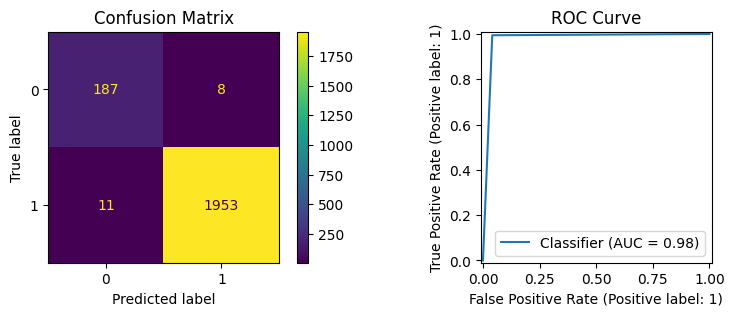

In [28]:
# Vizulize the valdiation scores

cm = confusion_matrix(y_true, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Plot confusion matrix
axs[0].set_title('Confusion Matrix')
ConfusionMatrixDisplay(cm).plot(ax=axs[0])

# Plot ROC curve
axs[1].set_title('ROC Curve')
RocCurveDisplay.from_predictions(y_true, y_pred, ax=axs[1])

plt.show()


## Inference

In [18]:
# Load the test dataset
test_ts = CustomDataset(path, test=True, transform=val_transforms)

print(len(test_ts))

2698


In [19]:
# Create the test DataLoader
test_dl = DataLoader(test_ts,
                    batch_size=32,
                    num_workers=6,
                    shuffle=False)


In [ ]:
# Create the infrence function
def predict(model, test_loader):
    model.eval()
    y_pred = []

    with torch.no_grad():
        for inputs, _ in tqdm(test_loader, desc='Predicting', leave=False):
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()  # Remove any additional dimensions
            preds = (outputs > 0).long()  # Apply threshold at 0 to logits to get predictions
            y_pred.extend(preds.cpu().numpy())

    return y_pred

# Make predictions
y_pred = predict(model, test_dl)

In [35]:
import re
import pandas as pd
def extract_id(file_name):
    return re.search(r'\d+', file_name).group(0)

# Extract the IDs from the test dataset
test_ids = [extract_id(f) for f in test_ts.img_files]

# Create the submission DataFrame
submission_df = pd.DataFrame({'ID': test_ids, 'TARGET': y_pred})

In [38]:
# Change id to int
submission_df['ID'] = submission_df['ID'].astype(int)

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
